<a href="https://colab.research.google.com/github/KenichiCarter/CSCI-E25/blob/master/examples/vision/ipynb/image_classification_efficientnet_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification via fine-tuning with EfficientNet

**Author:** [Yixing Fu](https://github.com/yixingfu)<br>
**Date created:** 2020/06/30<br>
**Last modified:** 2023/07/10<br>
**Description:** Use EfficientNet with weights pre-trained on imagenet for Stanford Dogs classification.

In [2]:
import tensorflow as tf
print('TensorFlow version = ' + str(tf.__version__))


TensorFlow version = 2.18.0


## Introduction: what is EfficientNet

EfficientNet, first introduced in [Tan and Le, 2019](https://arxiv.org/abs/1905.11946)
is among the most efficient models (i.e. requiring least FLOPS for inference)
that reaches State-of-the-Art accuracy on both
imagenet and common image classification transfer learning tasks.

The smallest base model is similar to [MnasNet](https://arxiv.org/abs/1807.11626), which
reached near-SOTA with a significantly smaller model. By introducing a heuristic way to
scale the model, EfficientNet provides a family of models (B0 to B7) that represents a
good combination of efficiency and accuracy on a variety of scales. Such a scaling
heuristics (compound-scaling, details see
[Tan and Le, 2019](https://arxiv.org/abs/1905.11946)) allows the
efficiency-oriented base model (B0) to surpass models at every scale, while avoiding
extensive grid-search of hyperparameters.

A summary of the latest updates on the model is available at
[here](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet), where various
augmentation schemes and semi-supervised learning approaches are applied to further
improve the imagenet performance of the models. These extensions of the model can be used
by updating weights without changing model architecture.

## B0 to B7 variants of EfficientNet

*(This section provides some details on "compound scaling", and can be skipped
if you're only interested in using the models)*

Based on the [original paper](https://arxiv.org/abs/1905.11946) people may have the
impression that EfficientNet is a continuous family of models created by arbitrarily
choosing scaling factor in as Eq.(3) of the paper.  However, choice of resolution,
depth and width are also restricted by many factors:

- Resolution: Resolutions not divisible by 8, 16, etc. cause zero-padding near boundaries
of some layers which wastes computational resources. This especially applies to smaller
variants of the model, hence the input resolution for B0 and B1 are chosen as 224 and
240.

- Depth and width: The building blocks of EfficientNet demands channel size to be
multiples of 8.

- Resource limit: Memory limitation may bottleneck resolution when depth
and width can still increase. In such a situation, increasing depth and/or
width but keep resolution can still improve performance.

As a result, the depth, width and resolution of each variant of the EfficientNet models
are hand-picked and proven to produce good results, though they may be significantly
off from the compound scaling formula.
Therefore, the keras implementation (detailed below) only provide these 8 models, B0 to B7,
instead of allowing arbitray choice of width / depth / resolution parameters.

## Keras implementation of EfficientNet

An implementation of EfficientNet B0 to B7 has been shipped with Keras since v2.3. To
use EfficientNetB0 for classifying 1000 classes of images from ImageNet, run:

```python
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')
```

This model takes input images of shape `(224, 224, 3)`, and the input data should be in the
range `[0, 255]`. Normalization is included as part of the model.

Because training EfficientNet on ImageNet takes a tremendous amount of resources and
several techniques that are not a part of the model architecture itself. Hence the Keras
implementation by default loads pre-trained weights obtained via training with
[AutoAugment](https://arxiv.org/abs/1805.09501).

For B0 to B7 base models, the input shapes are different. Here is a list of input shape
expected for each model:

| Base model | resolution|
|----------------|-----|
| EfficientNetB0 | 224 |
| EfficientNetB1 | 240 |
| EfficientNetB2 | 260 |
| EfficientNetB3 | 300 |
| EfficientNetB4 | 380 |
| EfficientNetB5 | 456 |
| EfficientNetB6 | 528 |
| EfficientNetB7 | 600 |

When the model is intended for transfer learning, the Keras implementation
provides a option to remove the top layers:
```
model = EfficientNetB0(include_top=False, weights='imagenet')
```
This option excludes the final `Dense` layer that turns 1280 features on the penultimate
layer into prediction of the 1000 ImageNet classes. Replacing the top layer with custom
layers allows using EfficientNet as a feature extractor in a transfer learning workflow.

Another argument in the model constructor worth noticing is `drop_connect_rate` which controls
the dropout rate responsible for [stochastic depth](https://arxiv.org/abs/1603.09382).
This parameter serves as a toggle for extra regularization in finetuning, but does not
affect loaded weights. For example, when stronger regularization is desired, try:

```python
model = EfficientNetB0(weights='imagenet', drop_connect_rate=0.4)
```
The default value is 0.2.

## Example: EfficientNetB0 for Stanford Dogs.

EfficientNet is capable of a wide range of image classification tasks.
This makes it a good model for transfer learning.
As an end-to-end example, we will show using pre-trained EfficientNetB0 on
[Stanford Dogs](http://vision.stanford.edu/aditya86/ImageNetDogs/main.html) dataset.

## Setup and data loading

In [3]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 64


### Loading data

Here we load data from [tensorflow_datasets](https://www.tensorflow.org/datasets)
(hereafter TFDS).
Stanford Dogs dataset is provided in
TFDS as [stanford_dogs](https://www.tensorflow.org/datasets/catalog/stanford_dogs).
It features 20,580 images that belong to 120 classes of dog breeds
(12,000 for training and 8,580 for testing).

By simply changing `dataset_name` below, you may also try this notebook for
other datasets in TFDS such as
[cifar10](https://www.tensorflow.org/datasets/catalog/cifar10),
[cifar100](https://www.tensorflow.org/datasets/catalog/cifar100),
[food101](https://www.tensorflow.org/datasets/catalog/food101),
etc. When the images are much smaller than the size of EfficientNet input,
we can simply upsample the input images. It has been shown in
[Tan and Le, 2019](https://arxiv.org/abs/1905.11946) that transfer learning
result is better for increased resolution even if input images remain small.

In [4]:
dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.K5FM8O_0.2.0/stanford_dogs-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.K5FM8O_0.2.0/stanford_dogs-test.tfrecord*...:   0…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


When the dataset include images with various size, we need to resize them into a
shared size. The Stanford Dogs dataset includes only images at least 200x200
pixels in size. Here we resize the images to the input size needed for EfficientNet.

In [5]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

### Visualizing the data

The following code shows the first 9 images with their labels.

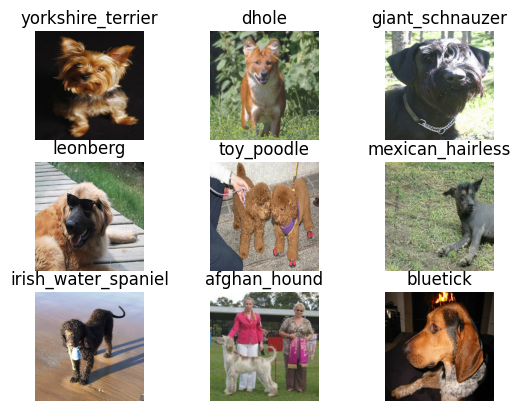

In [6]:

def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


### Data augmentation

We can use the preprocessing layers APIs for image augmentation.

In [7]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images


This `Sequential` model object can be used both as a part of
the model we later build, and as a function to preprocess
data before feeding into the model. Using them as function makes
it easy to visualize the augmented images. Here we plot 9 examples
of augmentation result of a given figure.

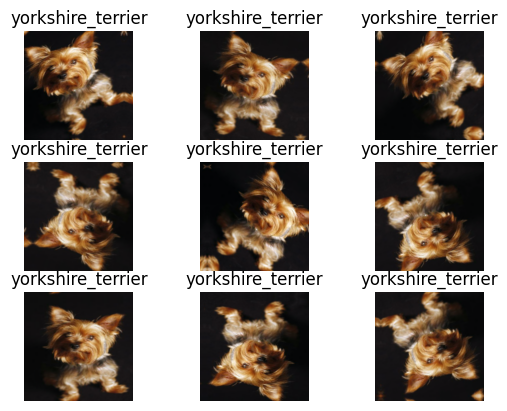

In [8]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")


### Prepare inputs

Once we verify the input data and augmentation are working correctly,
we prepare dataset for training. The input data are resized to uniform
`IMG_SIZE`. The labels are put into one-hot
(a.k.a. categorical) encoding. The dataset is batched.

Note: `prefetch` and `AUTOTUNE` may in some situation improve
performance, but depends on environment and the specific dataset used.
See this [guide](https://www.tensorflow.org/guide/data_performance)
for more information on data pipeline performance.

In [ ]:

# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)


## Training a model from scratch

We build an EfficientNetB0 with 120 output classes, that is initialized from scratch:

Note: the accuracy will increase very slowly and may overfit.

In [ ]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

epochs = 40  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)


Training the model is relatively fast. This might make it sounds easy to simply train EfficientNet on any
dataset wanted from scratch. However, training EfficientNet on smaller datasets,
especially those with lower resolution like CIFAR-100, faces the significant challenge of
overfitting.

Hence training from scratch requires very careful choice of hyperparameters and is
difficult to find suitable regularization. It would also be much more demanding in resources.
Plotting the training and validation accuracy
makes it clear that validation accuracy stagnates at a low value.

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

## Transfer learning from pre-trained weights

Here we initialize the model with pre-trained ImageNet weights,
and we fine-tune it on our own dataset.

In [ ]:

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


The first step to transfer learning is to freeze all layers and train only the top
layers. For this step, a relatively large learning rate (1e-2) can be used.
Note that validation accuracy and loss will usually be better than training
accuracy and loss. This is because the regularization is strong, which only
suppresses training-time metrics.

Note that the convergence may take up to 50 epochs depending on choice of learning rate.
If image augmentation layers were not
applied, the validation accuracy may only reach ~60%.

In [ ]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)

The second step is to unfreeze a number of layers and fit the model using smaller
learning rate. In this example we show unfreezing all layers, but depending on
specific dataset it may be desireble to only unfreeze a fraction of all layers.

When the feature extraction with
pretrained model works good enough, this step would give a very limited gain on
validation accuracy. In our case we only see a small improvement,
as ImageNet pretraining already exposed the model to a good amount of dogs.

On the other hand, when we use pretrained weights on a dataset that is more different
from ImageNet, this fine-tuning step can be crucial as the feature extractor also
needs to be adjusted by a considerable amount. Such a situation can be demonstrated
if choosing CIFAR-100 dataset instead, where fine-tuning boosts validation accuracy
by about 10% to pass 80% on `EfficientNetB0`.

A side note on freezing/unfreezing models: setting `trainable` of a `Model` will
simultaneously set all layers belonging to the `Model` to the same `trainable`
attribute. Each layer is trainable only if both the layer itself and the model
containing it are trainable. Hence when we need to partially freeze/unfreeze
a model, we need to make sure the `trainable` attribute of the model is set
to `True`.

In [ ]:

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 4  # @param {type: "slider", min:4, max:10}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)

### Tips for fine tuning EfficientNet

On unfreezing layers:

- The `BatchNormalization` layers need to be kept frozen
([more details](https://keras.io/guides/transfer_learning/)).
If they are also turned to trainable, the
first epoch after unfreezing will significantly reduce accuracy.
- In some cases it may be beneficial to open up only a portion of layers instead of
unfreezing all. This will make fine tuning much faster when going to larger models like
B7.
- Each block needs to be all turned on or off. This is because the architecture includes
a shortcut from the first layer to the last layer for each block. Not respecting blocks
also significantly harms the final performance.

Some other tips for utilizing EfficientNet:

- Larger variants of EfficientNet do not guarantee improved performance, especially for
tasks with less data or fewer classes. In such a case, the larger variant of EfficientNet
chosen, the harder it is to tune hyperparameters.
- EMA (Exponential Moving Average) is very helpful in training EfficientNet from scratch,
but not so much for transfer learning.
- Do not use the RMSprop setup as in the original paper for transfer learning. The
momentum and learning rate are too high for transfer learning. It will easily corrupt the
pretrained weight and blow up the loss. A quick check is to see if loss (as categorical
cross entropy) is getting significantly larger than log(NUM_CLASSES) after the same
epoch. If so, the initial learning rate/momentum is too high.
- Smaller batch size benefit validation accuracy, possibly due to effectively providing
regularization.